In [2]:
from tqdm import tqdm
from time import time
from tqdm import trange

import matplotlib.pyplot as plt
import numpy as np
import scipy

import jax
import jax.flatten_util as flatten_util
import jax.numpy as jnp

from flax import linen as nn

In [3]:
seed = 0

In [4]:
class ResNet(nn.Module):
    """A simple ResNet model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=50)(jnp.sin(2 * jnp.pi * x))
        x = nn.tanh(x)

        y = nn.Dense(features=50)(x)
        x = x + nn.tanh(y)

        y = nn.Dense(features=50)(x)
        x = x + nn.tanh(y)

        y = nn.Dense(features=50)(x)
        x = x + nn.tanh(y)

        x = nn.Dense(features=1)(x)
        return x


model_fn = ResNet()

In [4]:
def scalar_model_fn(params, batch):
    return model_fn.apply(params, batch)[0]


model_grad = jax.value_and_grad(scalar_model_fn, argnums=0)


def raveled_grad_fn(params, batch):
    value, grad = model_grad(params, batch)
    return value, flatten_util.ravel_pytree(grad)[0]


jacobian_fn = jax.jit(jax.vmap(raveled_grad_fn, in_axes=(None, 0), out_axes=(0, 0)))

In [5]:
# Target function = linear combination of Chebyshev polynomials
key = jax.random.PRNGKey(seed)
ord = 15

coeff = jax.random.normal(key, shape=(ord,))
poly = np.polynomial.chebyshev.Chebyshev(coeff)

def target_fn(x):
    return poly(jnp.sin(2 * jnp.pi * x)) / np.sqrt(ord)

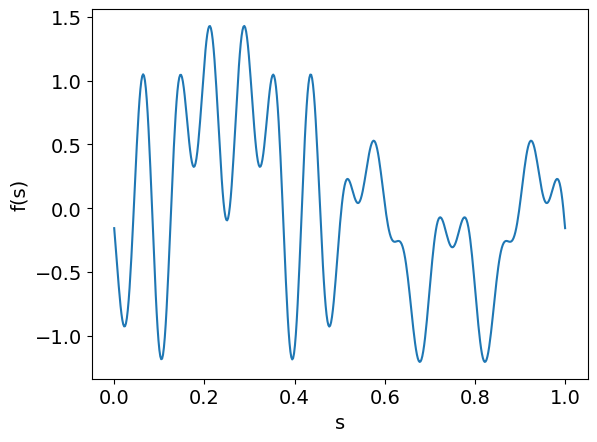

In [6]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

xs = np.linspace(0,1,500)
plt.plot(xs, target_fn(xs))
plt.xlabel("s")
plt.ylabel("f(s)")
plt.savefig("target_fn.pdf", bbox_inches='tight')

In [7]:
def loss_fn(model_params, xs):
    """Mean-squared error loss"""
    predictions = model_fn.apply(model_params, xs)
    targets = target_fn(xs)

    return jnp.mean((predictions - targets) ** 2)


loss_fn_grad = jax.jit(jax.value_and_grad(loss_fn, argnums=0))

In [8]:
rng = jax.random.PRNGKey(seed)

rng, key = jax.random.split(rng)
dummy_x = jax.random.uniform(key, shape=(100, 1))

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)
param_vec, unravel_fn = flatten_util.ravel_pytree(params)

initial_params = params


# Optimizer

In [9]:
def get_NGD_optimizer(params, rng, dummy_x, eta, lamb):
    param_vec, unravel_fn = flatten_util.ravel_pytree(params)
    opt_state = []

    def step(params, batch, opt_state, rng):
        batch_size = batch.shape[0]

        predictions, jacobian = jacobian_fn(params, batch)
        targets = target_fn(batch)[:, 0]
        residuals = (targets - predictions)

        loss = jnp.sum(residuals**2) / batch_size

        jacobian /= jnp.sqrt(batch_size)
        residuals /= jnp.sqrt(batch_size)

        T = jacobian @ jacobian.T + lamb * jnp.eye(batch_size)

        ravel_update = jacobian.T @ jax.scipy.linalg.solve(T, residuals, assume_a="pos")

        update = unravel_fn(ravel_update)
        params = jax.tree_map(lambda p, u: p + eta * u, params, update)

        return params, [], rng, loss, None

    return opt_state, jax.jit(step), rng



# Run optimization loop

In [10]:
rng = jax.random.PRNGKey(seed)

lamb = 1e-2
eta = 0.5
num_it = 1000

rng, key = jax.random.split(rng)
params = model_fn.init(key, dummy_x)


param_list = []
loss_list = []

opt_state, opt_step, rng  = get_NGD_optimizer(params, rng, dummy_x, eta, lamb)

batch_size = 200

# Training loop
with trange(num_it, unit="its") as pbar:
    for i in pbar:
        rng, key = jax.random.split(rng)
        batch = jax.random.uniform(key, shape=(batch_size, 1))

        params, opt_state, rng, loss, aux = opt_step(params, batch, opt_state, rng)

        if aux is not None:
            pbar.set_description(f"Loss {loss:.3e}, Aux: {aux:.3e}")
        else:
            pbar.set_description(f"Loss {loss:.3e}")

        param_list.append(params)
        loss_list.append(loss)

  0%|          | 0/1000 [00:00<?, ?its/s]<ipython-input-9-9d38f7235677>:22: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  params = jax.tree_map(lambda p, u: p + eta * u, params, update)
Loss 1.324e-05: 100%|██████████| 1000/1000 [00:08<00:00, 117.37its/s]


In [11]:
start_it = 20
mid_it = np.min(np.nonzero(np.array(loss_list) < 1e-2))
end_it = 800



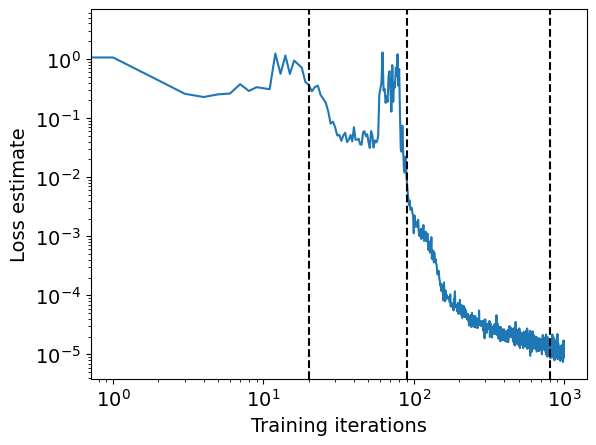

In [12]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

plt.plot(loss_list)
plt.axvline(start_it, color='black', linestyle='--')
plt.axvline(mid_it, color='black', linestyle='--')
plt.axvline(end_it, color='black', linestyle='--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Training iterations")
plt.ylabel("Loss estimate")

plt.savefig(f"NN_training.pdf", bbox_inches='tight')

# Test least-squares solvers

In [ ]:
def get_rbk_step():
    def rbk_step(x, AS, bS):
        return x + jax.numpy.linalg.lstsq(AS, bS - AS @ x, rcond=-1)[0]

    return jax.jit(rbk_step)

def get_reblock_step(lamb=0.001):
    def reblock_step(x, AS, bS):
        k = AS.shape[0]
        return x + AS.T @ jax.scipy.linalg.solve(AS @ AS.T + lamb * k * np.eye(k), bS - AS @ x, assume_a='pos')

    return jax.jit(reblock_step)


def get_minibatch_sgd_step(eta=0.01):
    def minibatch_sgd_step(x, AS, bS):
        k = AS.shape[0]
        return x + eta * AS.T @ (bS - AS @ x) / k

    return jax.jit(minibatch_sgd_step)

In [ ]:
def block_kaczmarz(params, k, T, take_step):
    rng = jax.random.PRNGKey(seed)

    n = flatten_util.ravel_pytree(params)[0].shape[0]
    x_kaczmarz = jnp.zeros(n)
    xs = np.zeros((T+1, n))
    xs[0,:] = x_kaczmarz

    def run_iteration(x_kaczmarz, rng):
        rng, key = jax.random.split(rng)
        S = jax.random.uniform(key, shape=(k, 1))
        fthetaS, JS = jacobian_fn(params, S)
        rS = target_fn(S[:,0]) - fthetaS

        return take_step(x_kaczmarz, JS, rS), rng

    run_iteration = jax.jit(run_iteration)

    for t in tqdm(range(T)):
        x_kaczmarz, rng = run_iteration(x_kaczmarz, rng)
        xs[t+1,:] = x_kaczmarz

    return xs

In [ ]:
k = 30
K = 2 * 10**4
lamb = 0.001
r = 200

In [ ]:
def get_plot_data(data_list, t_burn, A, b):
    data = []
    m = A.shape[0]

    for (xs, tot_time) in tqdm(data_list):
        rate =  tot_time / xs.shape[0]
        Tburn = int(t_burn / rate)
        T_final = int(20 / rate) # Since total time plotted is 20s
        xs = xs[:T_final,:]
        nfreq = int(T_final / 1000) # Calculate 1000 data points for each curve

        xs_burn = xs[:Tburn:nfreq,:]
        ts_burn = np.arange(Tburn)[::nfreq] * rate

        xs_to_avg = xs[Tburn:,:]
        trim_T = (xs_to_avg.shape[0] // nfreq) * nfreq # Trim down to multiple of nfreq
        xs_to_avg = xs_to_avg[:trim_T,:]

        xs_to_avg = np.reshape(xs_to_avg, (xs_to_avg.shape[0] // nfreq, nfreq, xs_to_avg.shape[-1]))
        block_means = np.mean(xs_to_avg, axis=1) # Sum over blocks first to avoid computing cumsum over the individual iterates
        x_means = np.cumsum(block_means,axis=0) / np.expand_dims(np.arange(1, block_means.shape[0] + 1), axis=1)
        t_means = np.arange(Tburn,Tburn+trim_T,nfreq) * rate

        xs = np.concatenate([xs_burn, x_means], axis=0)
        ts = np.concatenate([ts_burn, t_means])

        res = xs @ A.T - np.expand_dims(b, axis=0)
        rel_res = np.linalg.norm(res, axis=-1) /  np.linalg.norm(b)

        data.append((ts, rel_res))

    return data


def plot_mean_residuals(plot_data, tburn, labels, styles):
    fig, ax = plt.subplots()

    for ((Ts, ys), label, style) in tqdm(zip(plot_data, labels, styles)):
        ax.plot(Ts, ys, label=label, linestyle=style, linewidth=2)

    ax.set_xlabel('Seconds')
    ax.set_ylabel(r'Relative residual $\tilde{r}$')
    ax.set_yscale('log')
    ax.legend(loc='upper right')
    ax.grid(axis='y')
    ax.set_xscale('log')
    ax.set_xlim([0.1,20])
    ax.axvline(tburn, color='black', dashes=[2,4], linewidth=0.5)

    return fig, ax

In [ ]:
def plot_SV(A, r):
    S = scipy.sparse.linalg.svds(A, k=r)[1]

    fig, ax = plt.subplots()
    ax.plot(np.flip(S))
    ax.grid(axis='y')
    ax.axvline(30, color='black', linestyle='dashed')
    ax.set_yscale('log')
    ax.set_xlabel("Singular value index $i$")
    ax.set_ylabel("Singular value $\sigma_i(A)$")

    return fig, ax

# First snapshot

In [ ]:
params = param_list[start_it]

In [ ]:
T_sgd = 50000
t_start = time()
x_sgd = block_kaczmarz(params, k, T_sgd, get_minibatch_sgd_step(eta=0.002))
t_sgd = (time() - t_start)

100%|██████████| 50000/50000 [00:20<00:00, 2413.79it/s]


In [ ]:
T_rbk = 8000
t_start = time()
x_rbk = block_kaczmarz(params, k, T_rbk, get_rbk_step())
t_rbk = (time() - t_start)

100%|██████████| 8000/8000 [00:22<00:00, 349.94it/s]


In [ ]:
T_reblock = 45000
t_start = time()
x_reblock = block_kaczmarz(params, k, T_reblock, get_reblock_step(lamb=lamb))
t_reblock = (time() - t_start)

100%|██████████| 45000/45000 [00:24<00:00, 1850.39it/s]


In [ ]:
rng = jax.random.PRNGKey(seed)
S = jax.random.uniform(rng, shape=(K, 1))

predictions, A = jacobian_fn(params, S)
b = target_fn(S[:,0]) - predictions

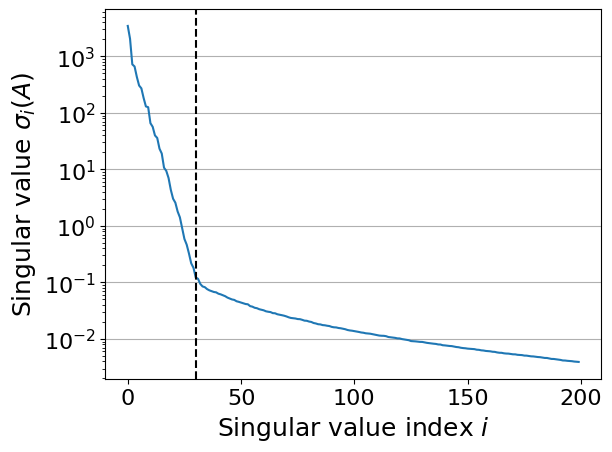

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_SV(np.array(A, dtype=np.float64),r)
fig.savefig(f"NN_start_spectrum.pdf", bbox_inches='tight')

In [ ]:
x_data = [x_sgd, x_rbk, x_reblock]
times = [t_sgd, t_rbk, t_reblock]
tburn = 1.0

In [ ]:
plot_data = get_plot_data(zip(x_data, times), tburn, A, b)

3it [00:01,  1.76it/s]


3it [00:00, 1422.76it/s]


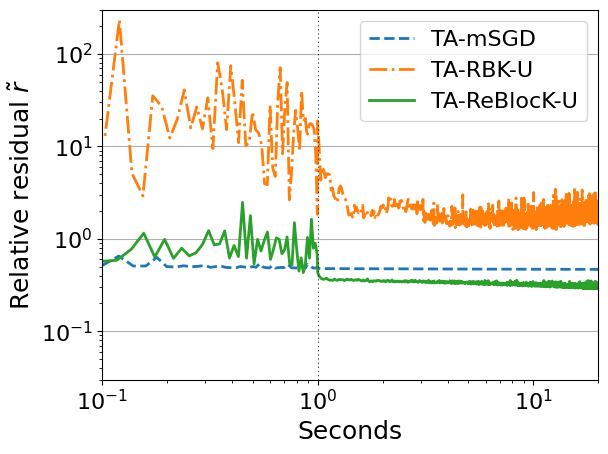

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

labels = ["TA-mSGD",  "TA-RBK-U", "TA-ReBlocK-U"]
styles = ['dashed', 'dashdot', 'solid']

fig, ax = plot_mean_residuals(plot_data, tburn, labels, styles)

ax.set_ylim([3e-2, 3e2])

plt.savefig(f'NN_start_ls.pdf', bbox_inches='tight')

# Second snapshot

In [ ]:
params = param_list[mid_it]

In [ ]:
T_sgd = 50000
t_start = time()
x_sgd = block_kaczmarz(params, k, T_sgd, get_minibatch_sgd_step(eta=0.002))
t_sgd = (time() - t_start)

100%|██████████| 50000/50000 [00:21<00:00, 2343.75it/s]


In [ ]:
T_rbk = 8000
t_start = time()
x_rbk = block_kaczmarz(params, k, T_rbk, get_rbk_step())
t_rbk = (time() - t_start)

100%|██████████| 8000/8000 [00:21<00:00, 380.94it/s]


In [ ]:
T_reblock = 45000
t_start = time()
x_reblock = block_kaczmarz(params, k, T_reblock, get_reblock_step(lamb=lamb))
t_reblock = (time() - t_start)

100%|██████████| 45000/45000 [00:23<00:00, 1923.01it/s]


In [ ]:
rng = jax.random.PRNGKey(seed)
S = jax.random.uniform(rng, shape=(K, 1))

predictions, A = jacobian_fn(params, S)
b = target_fn(S[:,0]) - predictions

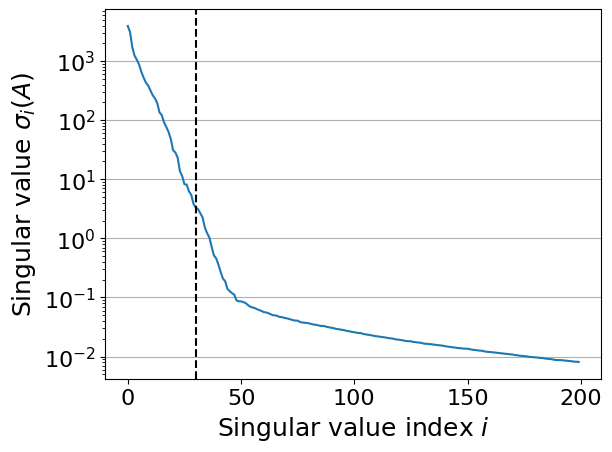

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_SV(np.array(A, dtype=np.float64),r)
fig.savefig(f"NN_mid_spectrum.pdf", bbox_inches='tight')

In [ ]:
x_data = [x_sgd, x_rbk, x_reblock]
times = [t_sgd, t_rbk, t_reblock]
tburn = 1

In [ ]:
plot_data = get_plot_data(zip(x_data, times), tburn, A, b)

3it [00:01,  1.96it/s]


3it [00:00, 1340.18it/s]


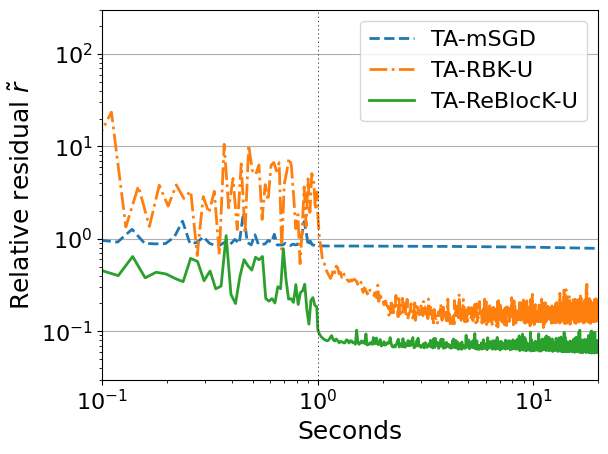

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

labels = ["TA-mSGD",  "TA-RBK-U", "TA-ReBlocK-U"]
styles = ['dashed', 'dashdot', 'solid']

fig, ax = plot_mean_residuals(plot_data, tburn, labels, styles)

ax.set_ylim([3e-2, 3e2])

plt.savefig(f'NN_mid_ls.pdf', bbox_inches='tight')

# Third snapshot

In [ ]:
params = param_list[end_it]

In [ ]:
T_sgd = 50000
t_start = time()
x_sgd = block_kaczmarz(params, k, T_sgd, get_minibatch_sgd_step(eta=0.002))
t_sgd = (time() - t_start)

100%|██████████| 50000/50000 [00:20<00:00, 2480.22it/s]


In [ ]:
T_rbk = 8000
t_start = time()
x_rbk = block_kaczmarz(params, k, T_rbk, get_rbk_step())
t_rbk = (time() - t_start)

100%|██████████| 8000/8000 [00:20<00:00, 381.13it/s]


In [ ]:
T_reblock = 45000
t_start = time()
x_reblock = block_kaczmarz(params, k, T_reblock, get_reblock_step(lamb=lamb))
t_reblock = (time() - t_start)

100%|██████████| 45000/45000 [00:23<00:00, 1951.90it/s]


In [ ]:
rng = jax.random.PRNGKey(seed)
S = jax.random.uniform(rng, shape=(K, 1))

predictions, A = jacobian_fn(params, S)
b = target_fn(S[:,0]) - predictions

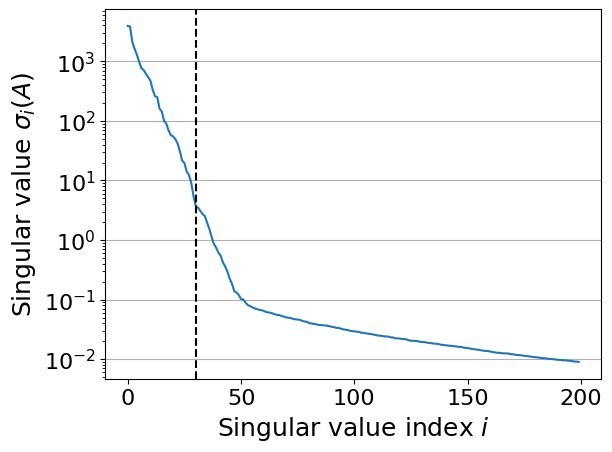

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

fig, ax = plot_SV(np.array(A, dtype=np.float64),r)
fig.savefig(f"NN_end_spectrum.pdf", bbox_inches='tight')

In [ ]:
x_data = [x_sgd, x_rbk, x_reblock]
times = [t_sgd, t_rbk, t_reblock]
tburn = 1

In [ ]:
plot_data = get_plot_data(zip(x_data, times), tburn, A, b)

3it [00:01,  1.73it/s]


3it [00:00, 1415.08it/s]


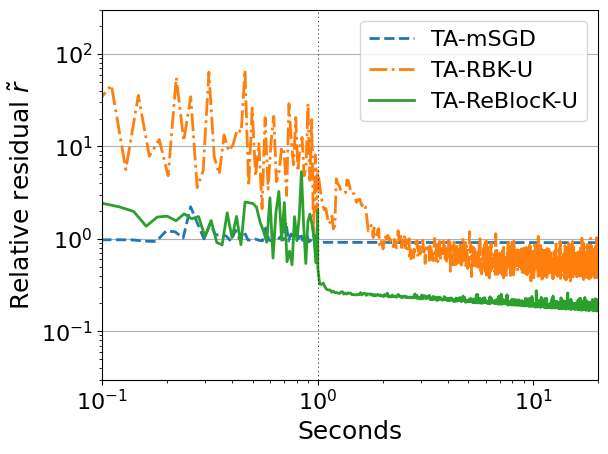

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})

labels = ["TA-mSGD",  "TA-RBK-U", "TA-ReBlocK-U"]
styles = ['dashed', 'dashdot', 'solid']

fig, ax = plot_mean_residuals(plot_data, tburn, labels, styles)

ax.set_ylim([3e-2, 3e2])

plt.savefig(f'NN_end_ls.pdf', bbox_inches='tight')

In [ ]:
print(T_sgd / t_sgd)
print(T_rbk / t_rbk)
print(T_reblock/ t_reblock)

2478.6918278004914
380.9252647966399
1950.9870624708162


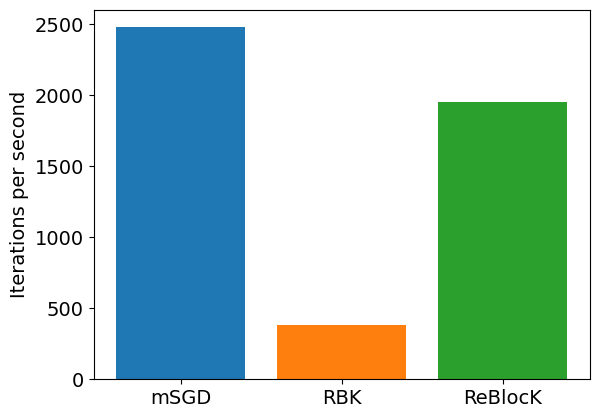

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})

fig, ax = plt.subplots()
ax.bar("mSGD", T_sgd / t_sgd)
ax.bar("RBK",  T_rbk / t_rbk)
ax.bar("ReBlocK", T_reblock/ t_reblock)
ax.set_ylabel("Iterations per second")
plt.savefig(f"it_speed.pdf", dpi=400, bbox_inches='tight')